**Исходные данные:**

   **base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id и вектор признаков размерностью 72.**

**target.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id, вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).**

**validation.csv - датасет с товарами (уникальный id и вектор признаков),для которых надо найти наиболее близкие товары из base.csv.**

**validation_answer.csv - правильные ответы к предыдущему файлу.**

**Цель проекта:**

**Разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv.**

**Оценить качество алгоритма по метрике accuracy@5.**

**1. Импорт библиотек и данных.**

Импортировал все необходимые библиотеки

In [59]:
!pip install faiss-cpu

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import faiss
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostClassifier, cv, Pool
from catboost import cv, Pool
import lightgbm as ltb

pd.set_option('display.max_columns', 80)
k = 50

Уменьшил объем памяти заменой float64 на float32

In [61]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

Прочитал файл с информацией о наборе товаров.

In [62]:
original_data = pd.read_csv('/kaggle/input/data-for-matching/base.csv', index_col=0, sep=',', dtype=dict_base)
original_data.info()
display(original_data.head(50))

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.812180,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.832840,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.979630,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,-108.470444,-104.537781,-82.388489,-79.986740,113.596313,-38.995880,-4.787360,8.327808,-124.855759,-79.109016,-107.943275,1479.170532,-125.271614,24.656485,-16.921055,813.770081,-182.680267,14.715704,-62.932701,151.201981,10.613454,-134.934341,58.777729,-529.295044,43.665924,92.806305,-38.936657,-145.045303,-124.295769,-36.876732,-17.742870,10.536242,-124.584152,121.914146,-17.321358,105.217239,-94.379646,-63.769272,29.217487,-26.423973,5.869829,64.061546,63.513279,-112.258102,80.926590,72.636101,-137.314316,7.912551,-62.188919,-540.321045,-89.588715,-149.326691,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,-110.342453,-38.982059,-50.228867,-26.690920,135.272903,-7.510103,8.924209,111.576950,-130.833191,-79.315849,-57.843952,1262.919678,19.225910,59.811813,76.159668,312.698914,-76.726974,21.299923,-24.069107,167.385529,-44.059471,-148.131851,98.042610,-657.524414,96.363167,71.061523,-36.563557,-135.372437,-123.708977,-44.739437,-10.855220,8.354800,-168.328857,215.928070,-32.975979,66.864883,30.838631,-211.540375,57.695343,-67.822632,-29.38913

Сохранил в отдельную переменную оригинальный датафрейм на всякий случай, а в копии убрал из индексов лишний текст.

In [63]:
data = original_data
data.index = original_data.index.str.replace('-base', '').astype('int')

Сохранил индексы датафрейма с товарами в отдельную переменную. С помощью нее я смогу сопоставлять ответы из других датафреймов с этим.

In [64]:
dataidx = pd.DataFrame(data.index) 
dataidx['Id'] = pd.to_numeric(dataidx['Id'], downcast = 'integer')
dataidx.head()

,Id
0,0
1,1
2,2
3,3
4,4


Теперь можно обновить индексы т.к. они идут непоследовательно.

In [65]:
data = data.reset_index(drop = True)

Прочитал даннные для обучения. Типы данных указаны корректно, пропуски отсутствуют.

In [66]:
train = pd.read_csv('/kaggle/input/data-for-matching/train.csv', index_col=0, sep=',', dtype=dict_base)
train.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,-146.517075,-159.469849,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789322,-78.737091,1507.231323,19.957405,34.834290,-8.820732,813.770081,-125.606796,17.584084,-58.452904,141.281799,-54.959309,-136.988541,63.880493,-1018.469543,89.228928,65.919960,-24.078644,-152.334106,-91.199379,-28.225389,-4.767386,0.158236,-129.128662,122.958366,-30.800995,123.623398,-37.540867,-72.139801,71.240990,-168.115585,118.236450,-18.065195,37.255718,-137.691040,87.500771,62.437290,-131.260635,35.692661,-86.038834,-379.339081,-153.465775,-131.198288,-61.567047,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,-107.153023,-8.800034,-50.977798,29.457338,143.389313,5.614824,-45.274761,9.643625,-77.554626,-79.066612,-77.926460,1507.231323,16.612400,116.284286,33.754898,813.770081,-105.765335,6.523008,-19.812988,157.693924,-20.604088,-146.591278,78.849571,-780.449158,87.560768,73.036659,16.891029,-144.657898,-116.122147,-19.353254,-7.709266,-5.394988,-140.252121,193.184967,-53.

Убрал лишний текст из индексов и столбца с экспертной оценкой.

In [67]:
train['Target'] = train['Target'].str.replace('-base', '').astype('int')
train['trainidx'] = train.index.str.replace('-query', '').astype('int')

Сопоставил индексы из оригинального датафрейма с товарами и ответы в тренировочной таблице. 

In [68]:
train = train.merge(dataidx.reset_index(), left_on = 'Target', right_on = 'Id').set_index('trainidx')
train = train.drop(['Target', 'Id'], axis = 1)
train = train.rename(columns = {'index': 'Target'}).sort_index()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21      100000 n

Сохранил ответы в отдельную переменную. Отбросил столбец с ответами из тренировочного датафрейма.

In [69]:
targets = train["Target"]
train = train.drop('Target', axis = 1)

Прочитал валидационный датасет.

In [70]:
valid = pd.read_csv('/kaggle/input/data-for-matching/validation.csv', index_col=0, sep=',', dtype=dict_base)
valid.info()
display(valid.head())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

Прочитал датасет с ответами.

In [71]:
answer = pd.read_csv('/kaggle/input/data-for-matching/validation_answer.csv', index_col=0, sep=',', dtype=dict_base)
answer.info()
display(answer.head())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Объединил валидационную таблиу с таблицей с ответами. Теперь она выглядит как тренировочная таблица и будет понятна для будущей модели. Также отбросил лишний текст в столбце с ответами и индексах.

In [72]:
valid = valid.merge(answer, left_on = valid.index, right_on = answer.index)
valid.index = valid['key_0']
valid = valid.drop('key_0', axis = 1)

valid['valididx'] = valid.index.str.replace('-query', '').astype('int')
valid['Expected'] = valid['Expected'].str.replace('-base', '').astype('int')

Сопоставил индексы из оригинального датафрейма и столбца с ответами.

In [73]:
valid = valid.merge(dataidx.reset_index(), left_on = 'Expected', right_on = 'Id').set_index('valididx')
valid = valid.drop(['Expected', 'Id'], axis = 1)
valid = valid.rename(columns = {'index': 'Expected'}).sort_index()
valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000 to 199999
Data columns (total 73 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   0         100000 non-null  float32
 1   1         100000 non-null  float32
 2   2         100000 non-null  float32
 3   3         100000 non-null  float32
 4   4         100000 non-null  float32
 5   5         100000 non-null  float32
 6   6         100000 non-null  float32
 7   7         100000 non-null  float32
 8   8         100000 non-null  float32
 9   9         100000 non-null  float32
 10  10        100000 non-null  float32
 11  11        100000 non-null  float32
 12  12        100000 non-null  float32
 13  13        100000 non-null  float32
 14  14        100000 non-null  float32
 15  15        100000 non-null  float32
 16  16        100000 non-null  float32
 17  17        100000 non-null  float32
 18  18        100000 non-null  float32
 19  19        100000 non-null  float32
 20  20  

In [74]:
expected = valid['Expected']
valid = valid.drop('Expected', axis = 1)

**2. Исследовательский анализ данных.**

Из таблицы нельзя удалять данные т.к. каждая строка относится к какому-либо реальному товару. Тем не менее мы можем оценить, есть ли явные выбросы. Для этого вывел диаграммы размаха по каждому из признаков. Распределение выглядит нормальным, явных выбросов и отклонений не выявлено.

'0'

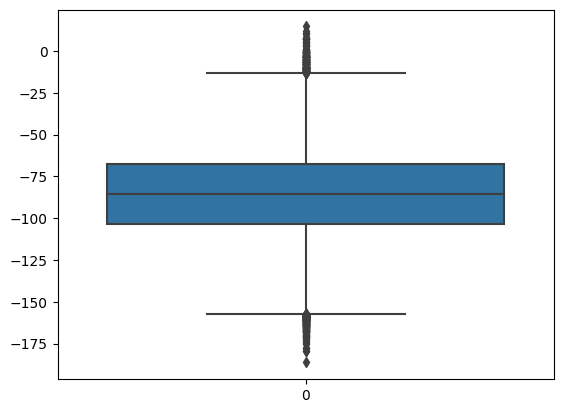

'1'

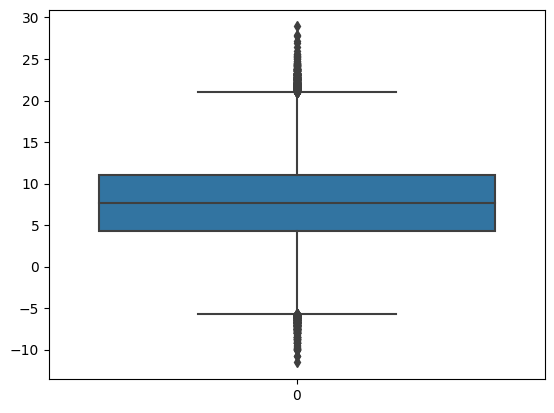

'2'

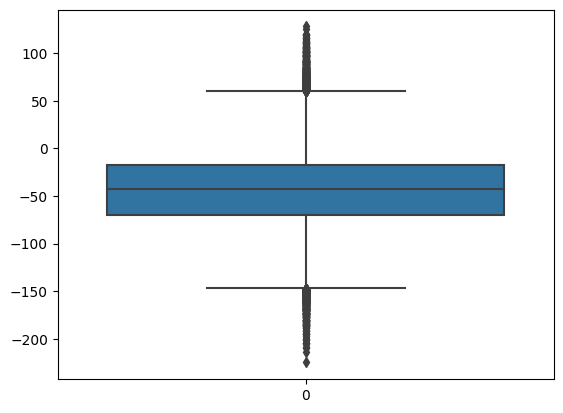

'3'

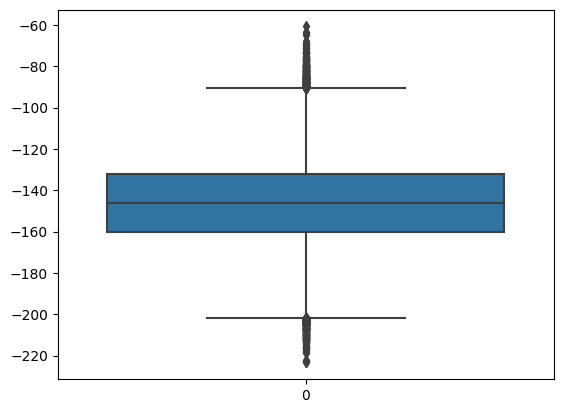

'4'

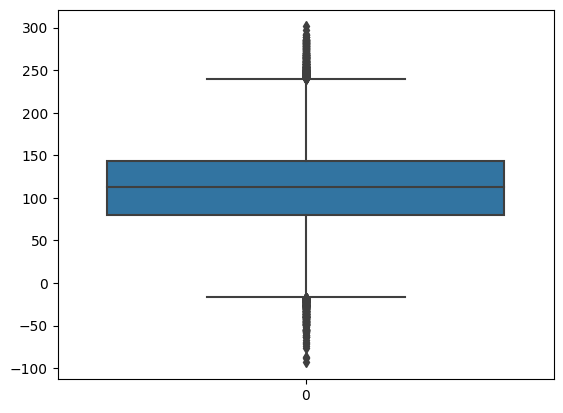

'5'

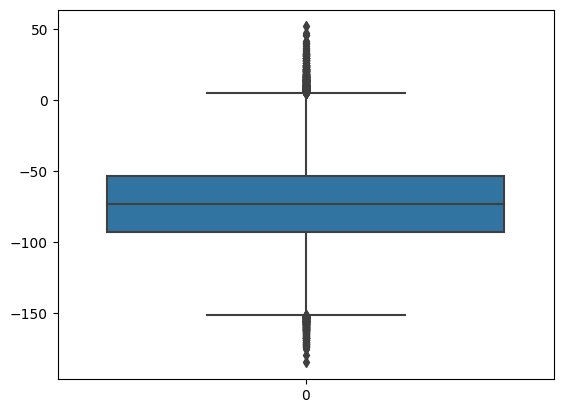

'6'

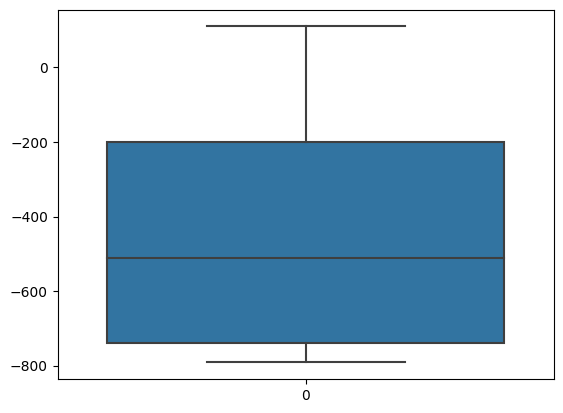

'7'

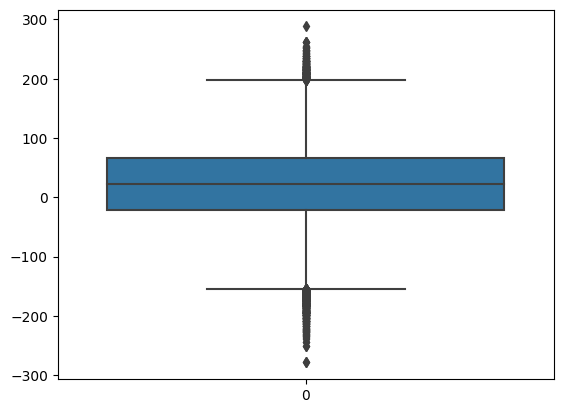

'8'

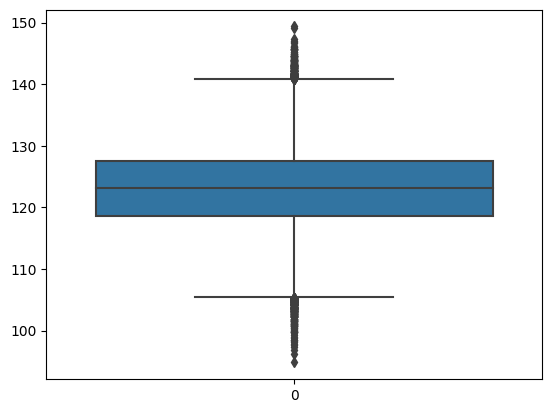

'9'

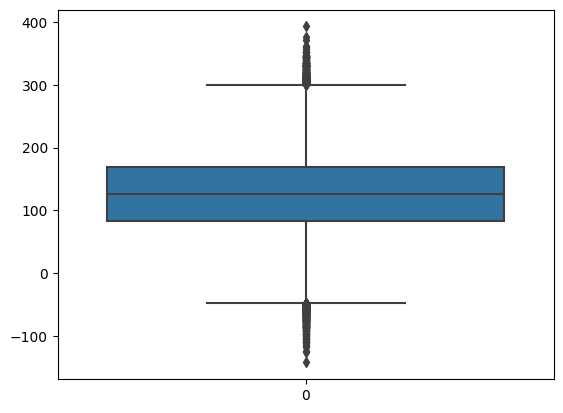

'10'

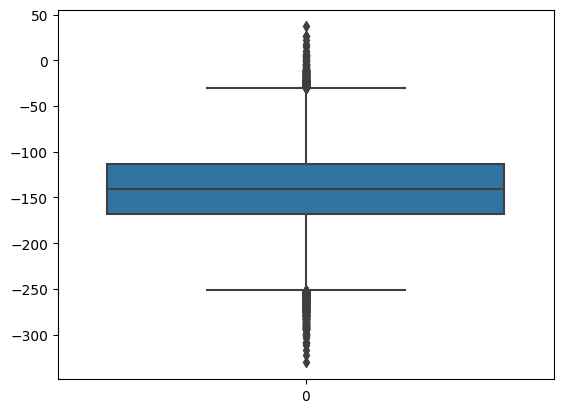

'11'

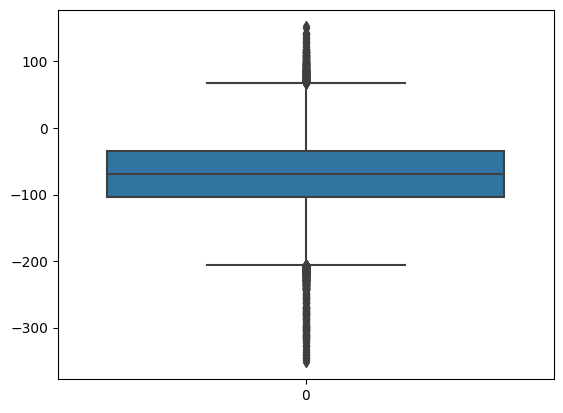

'12'

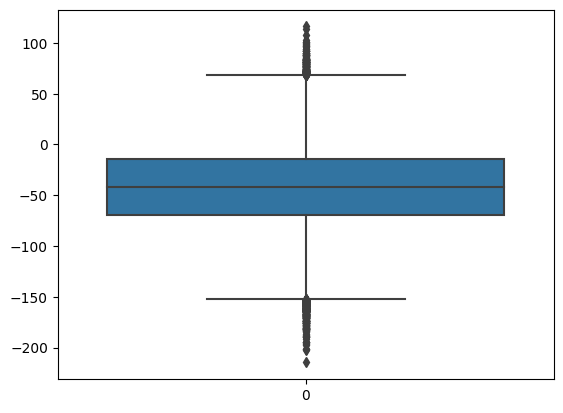

'13'

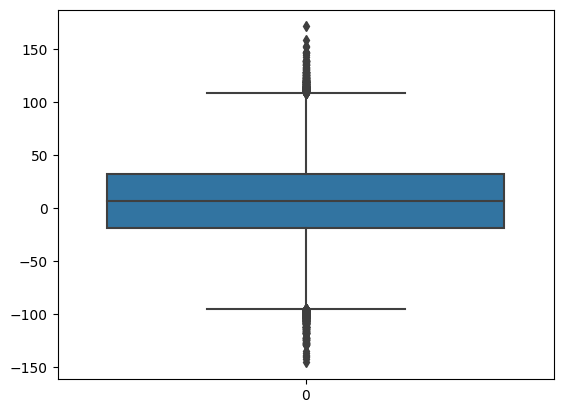

'14'

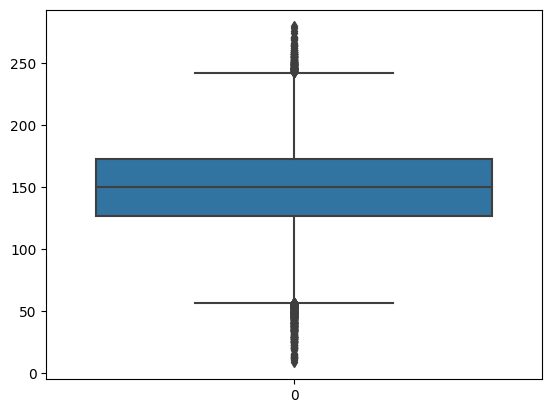

'15'

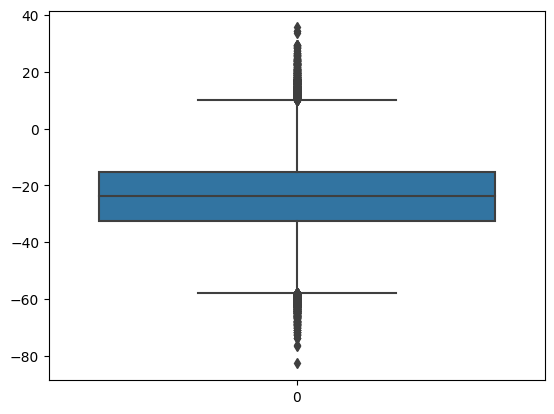

'16'

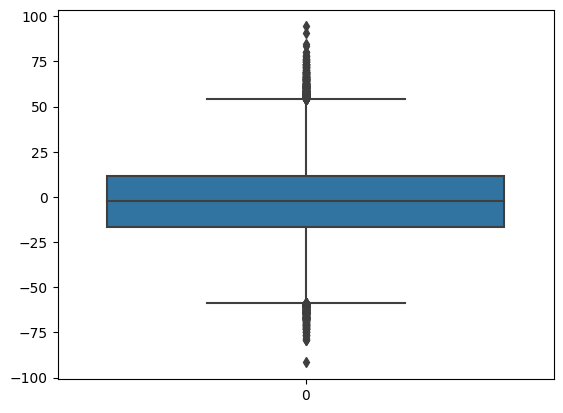

'17'

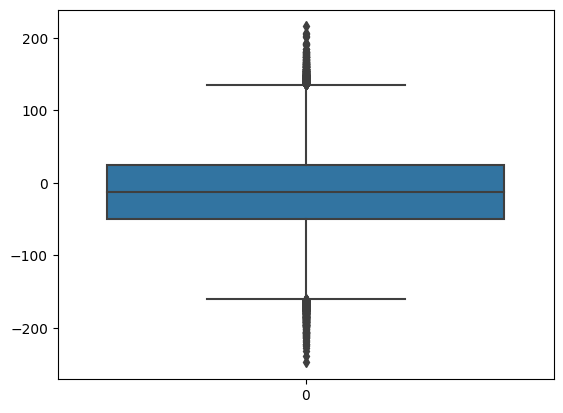

'18'

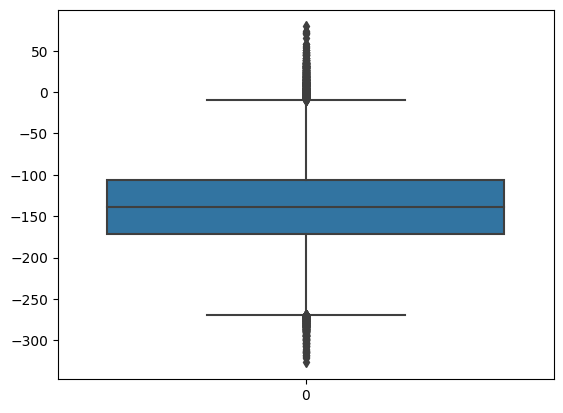

'19'

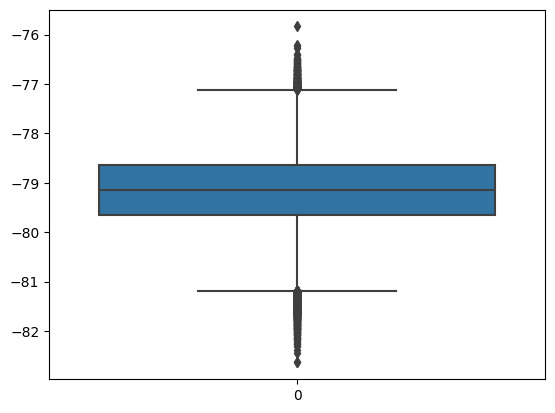

'20'

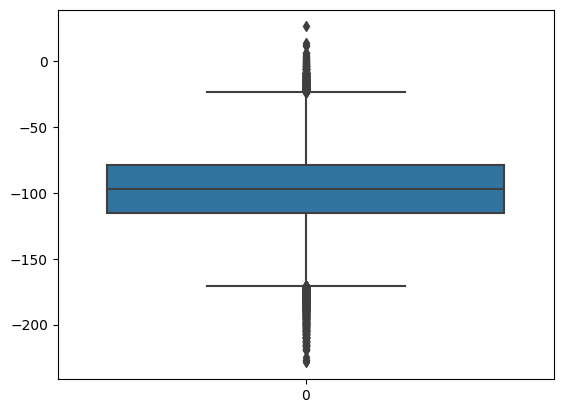

'21'

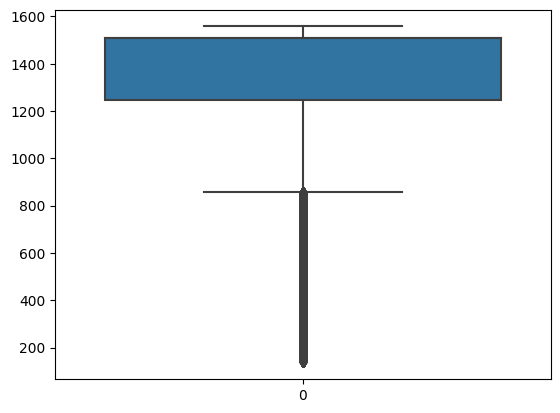

'22'

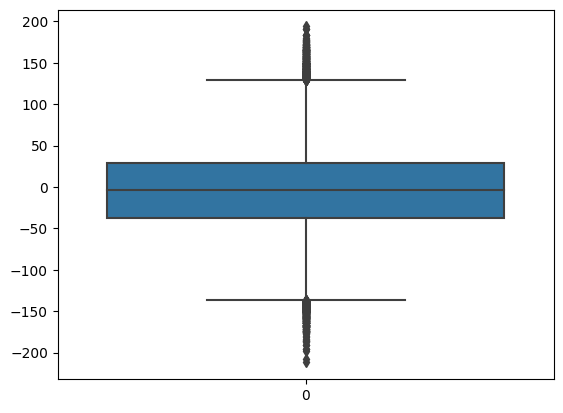

'23'

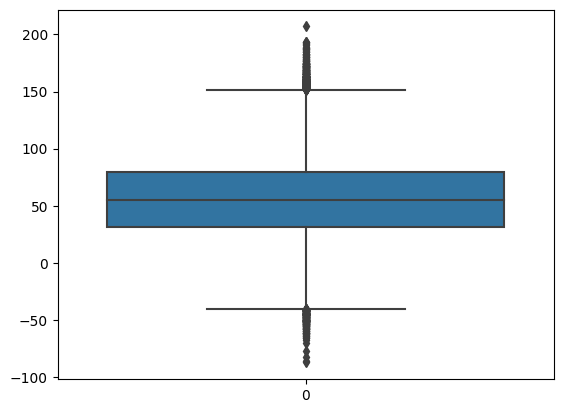

'24'

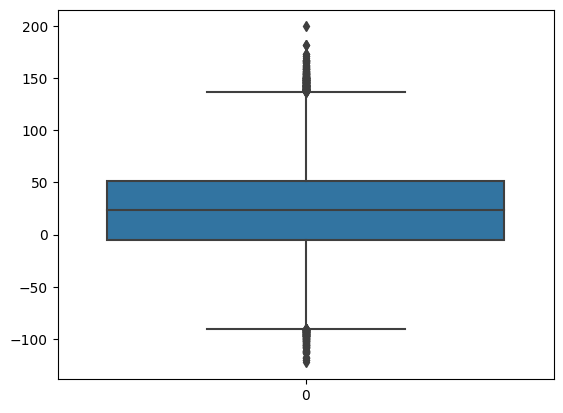

'25'

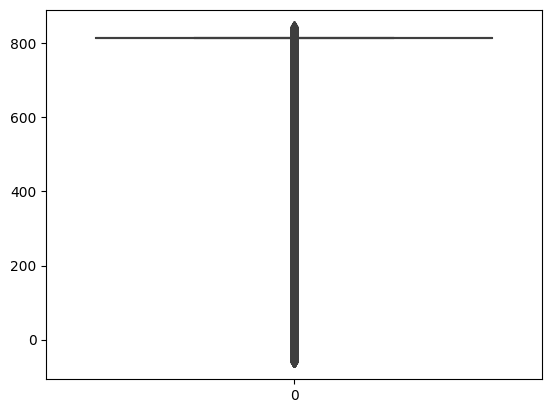

'26'

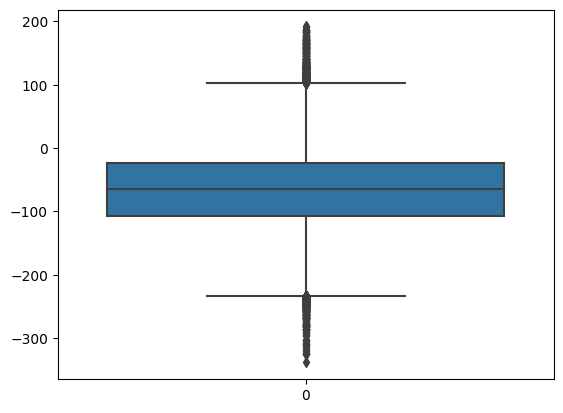

'27'

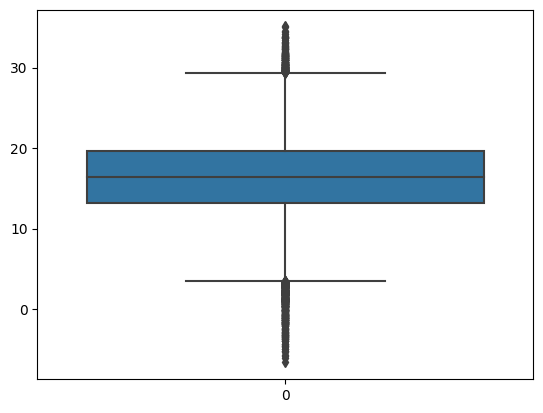

'28'

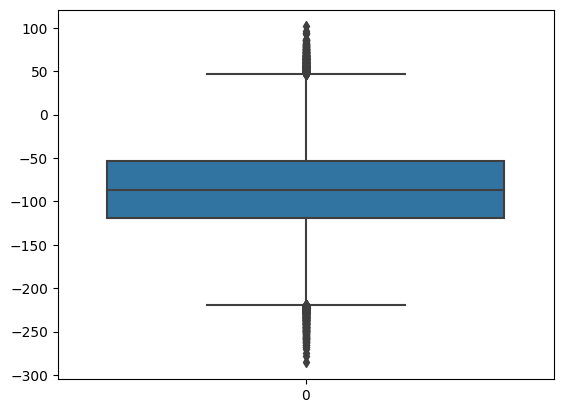

'29'

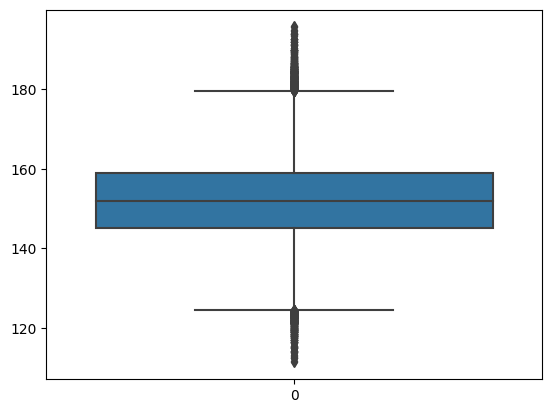

'30'

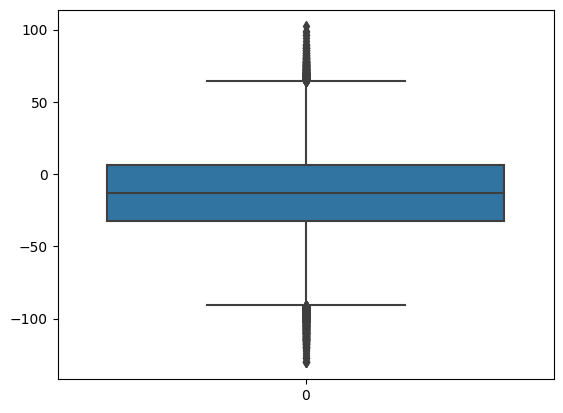

'31'

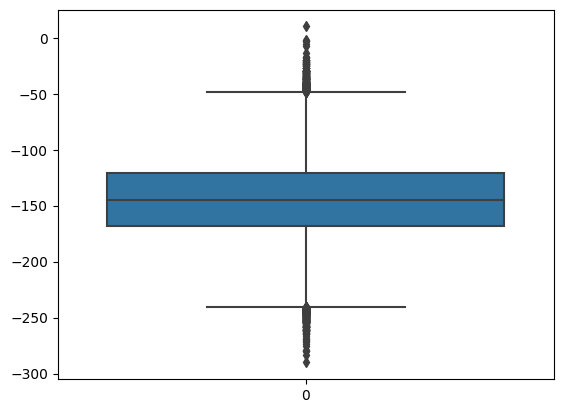

'32'

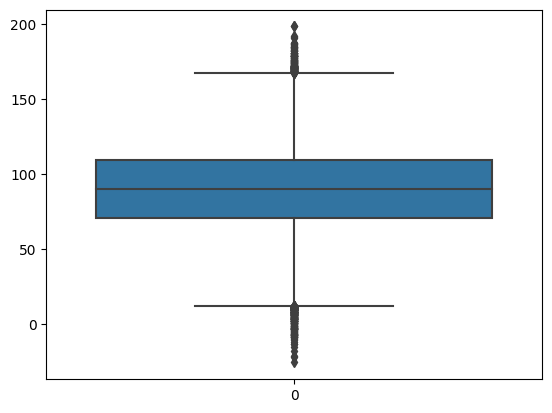

'33'

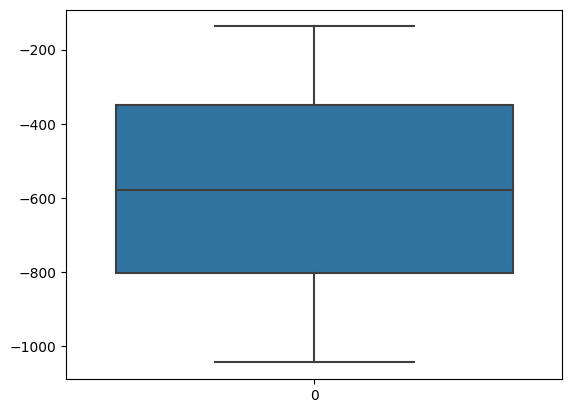

'34'

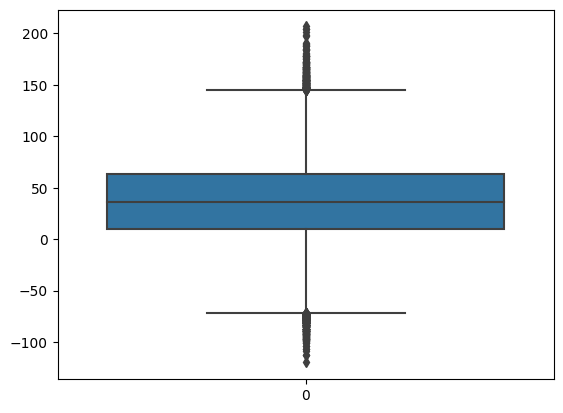

'35'

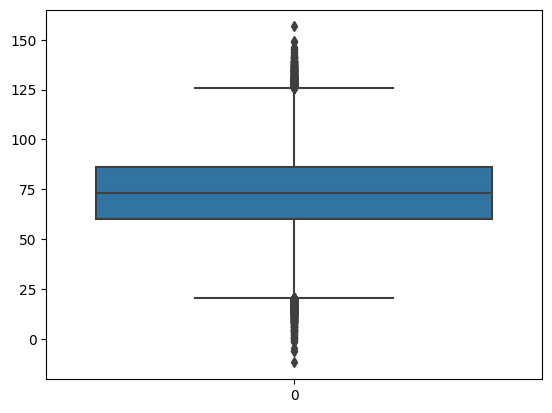

'36'

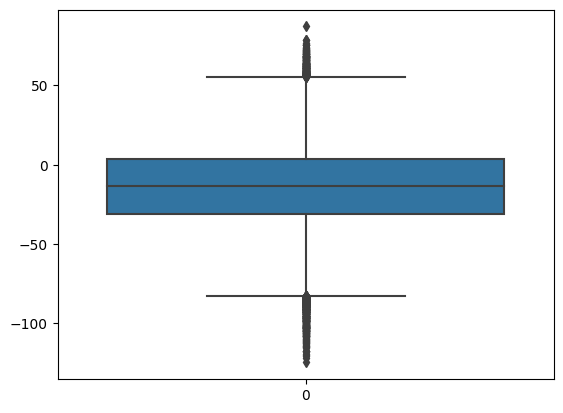

'37'

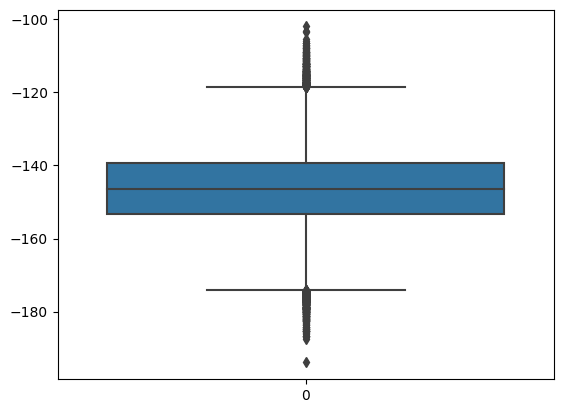

'38'

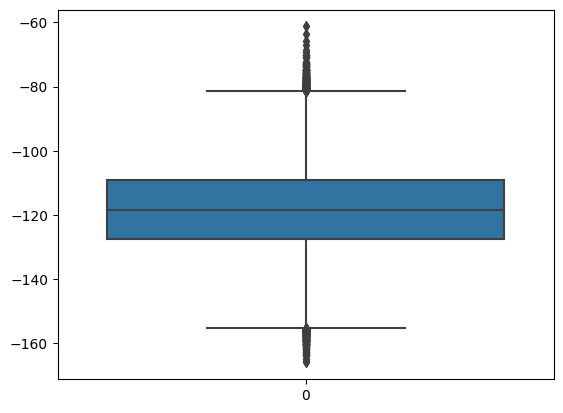

'39'

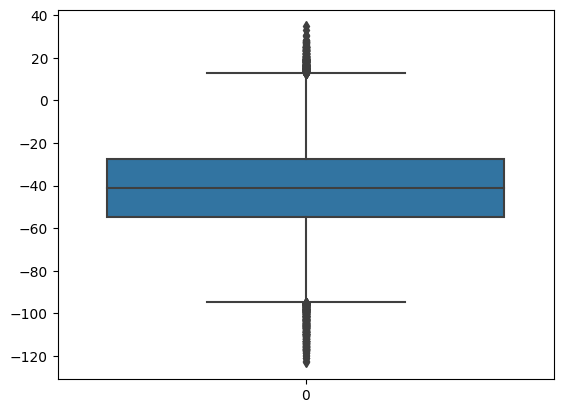

'40'

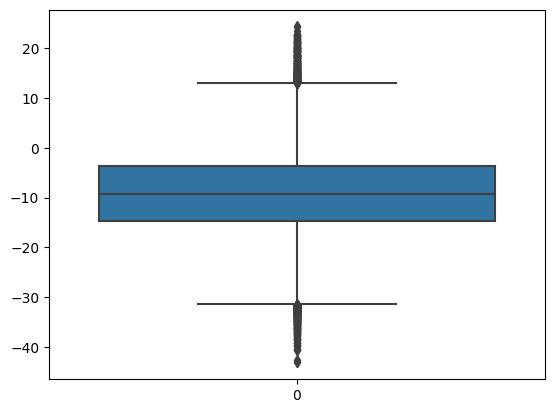

'41'

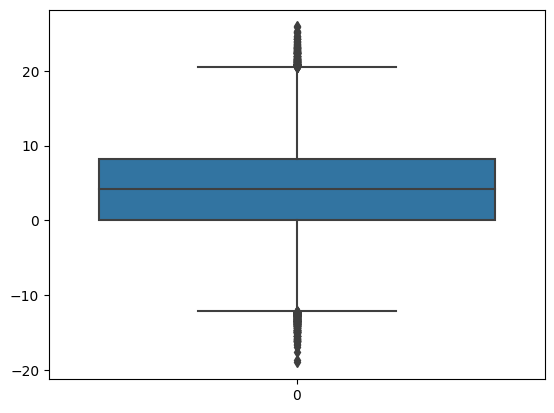

'42'

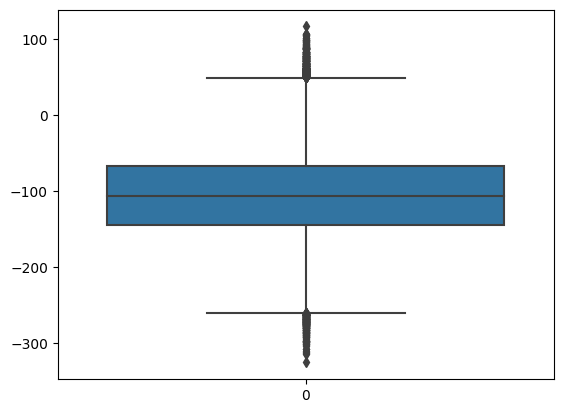

'43'

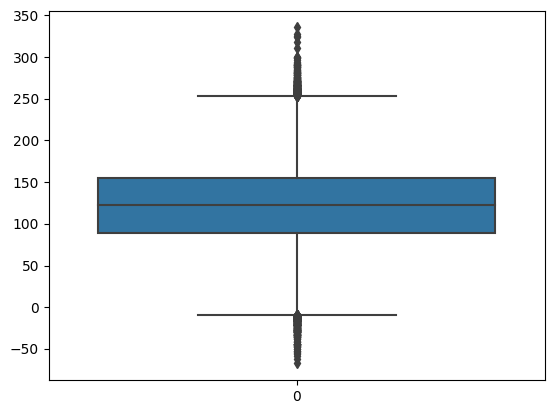

'44'

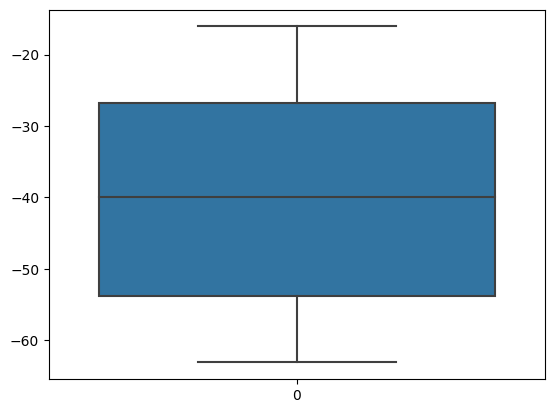

'45'

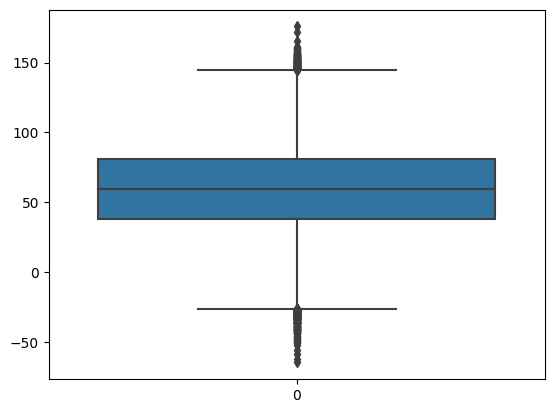

'46'

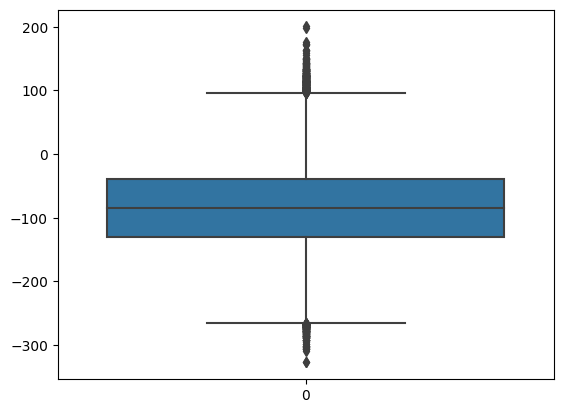

'47'

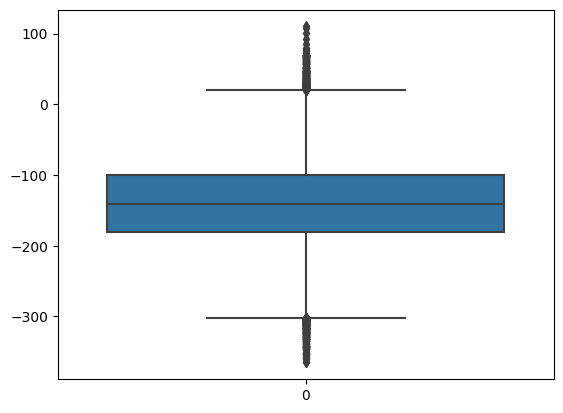

'48'

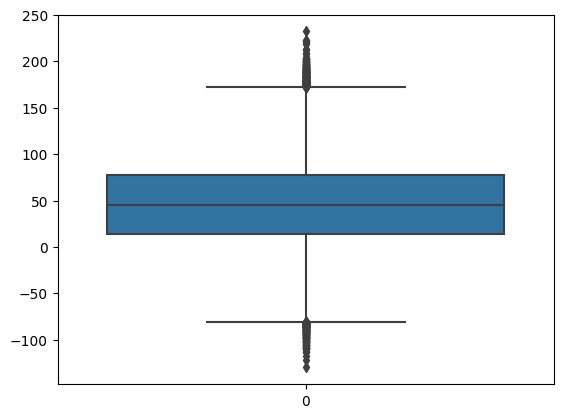

'49'

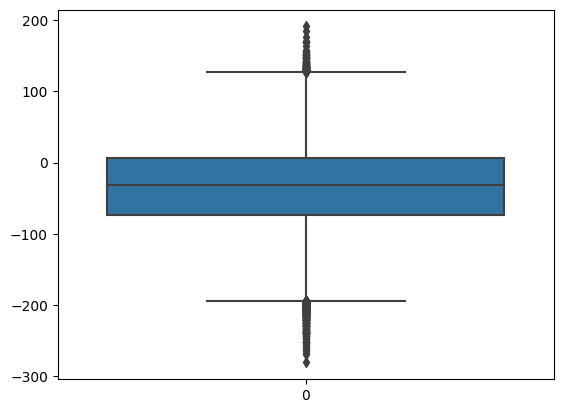

'50'

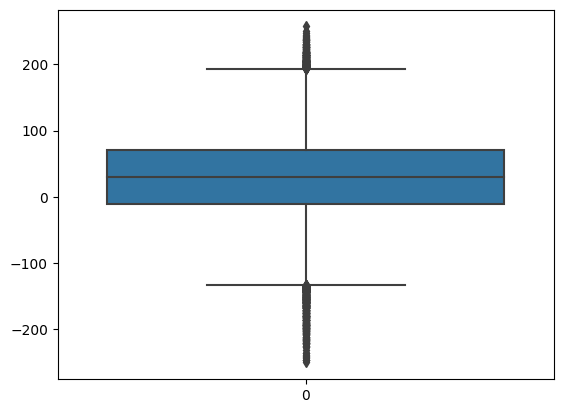

'51'

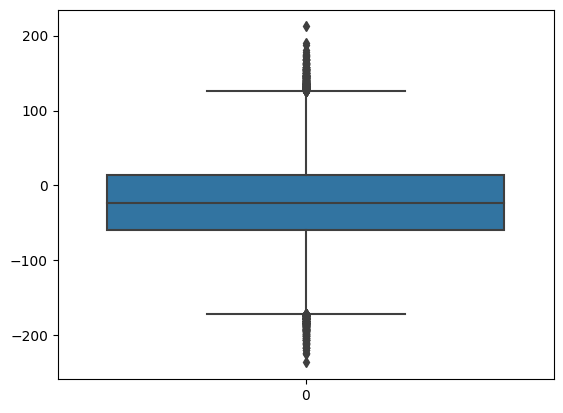

'52'

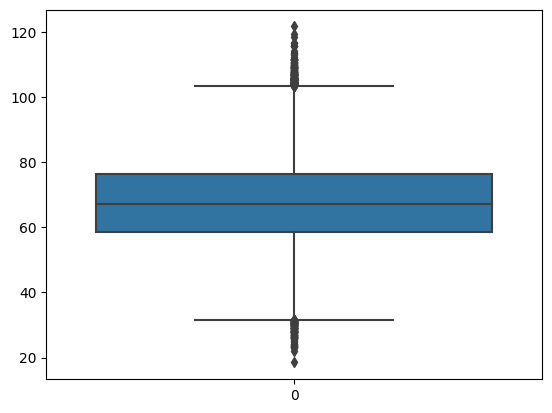

'53'

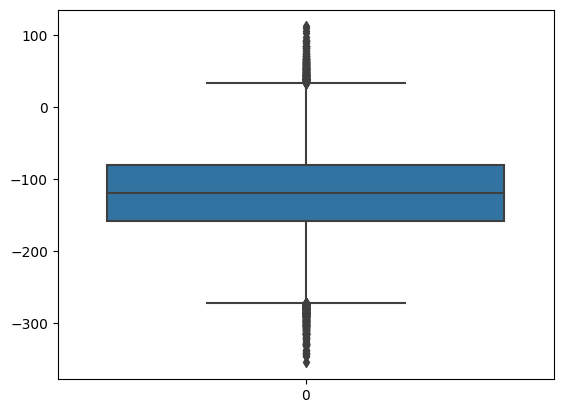

'54'

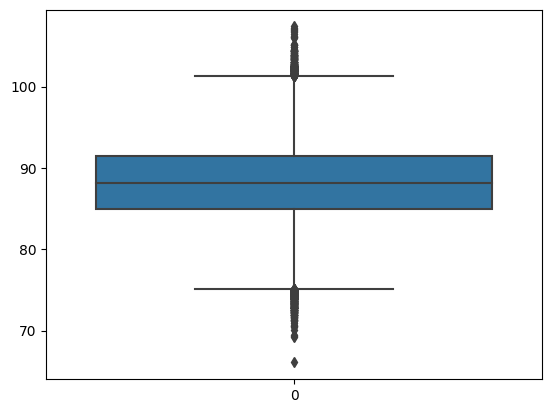

'55'

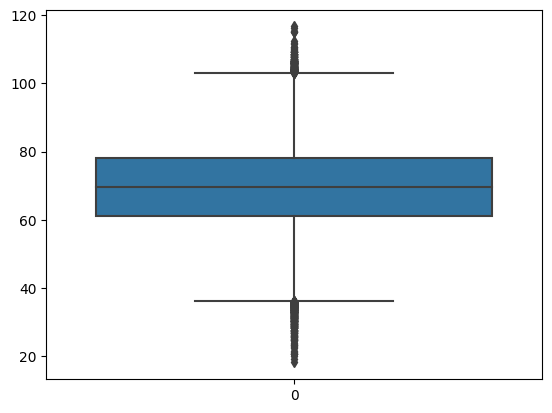

'56'

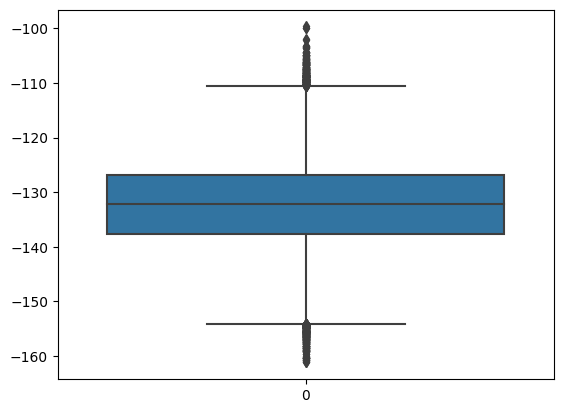

'57'

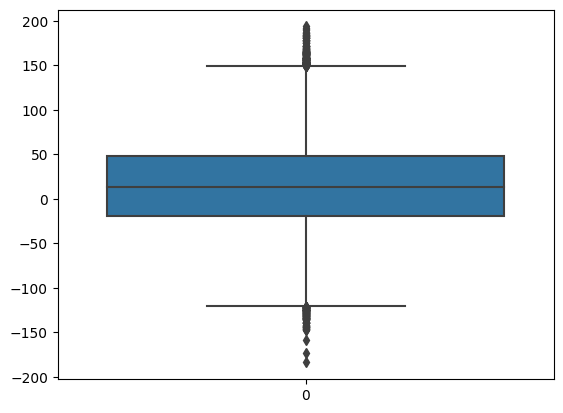

'58'

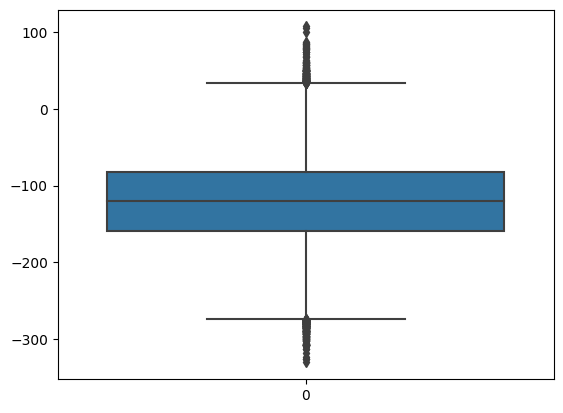

'59'

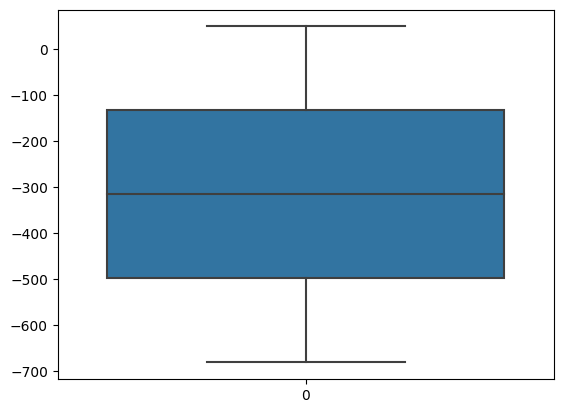

'60'

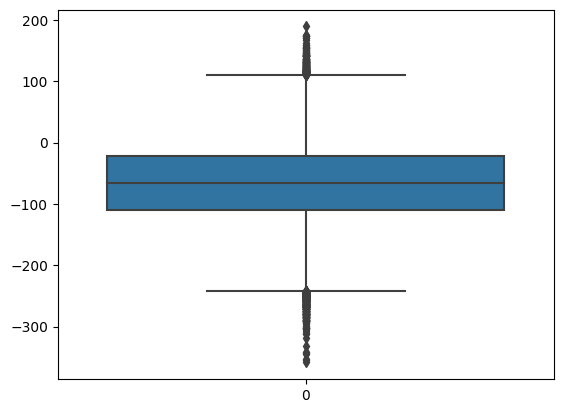

'61'

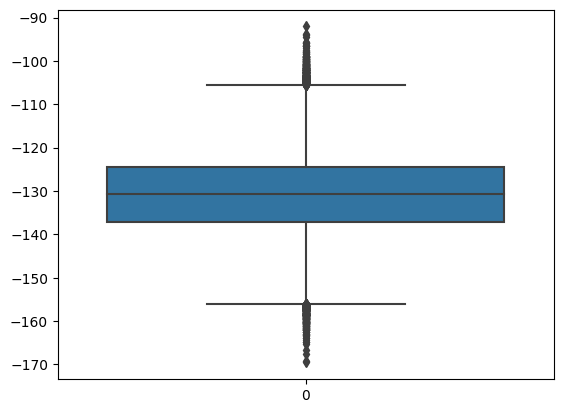

'62'

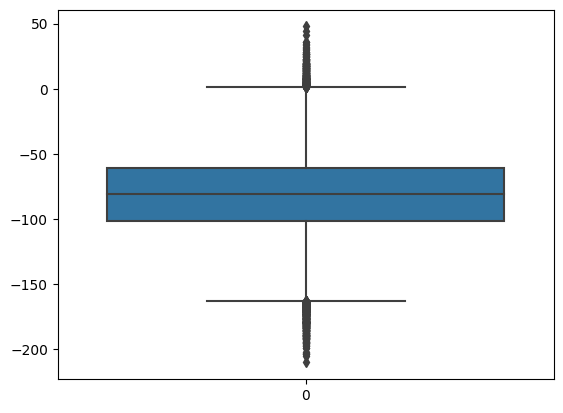

'63'

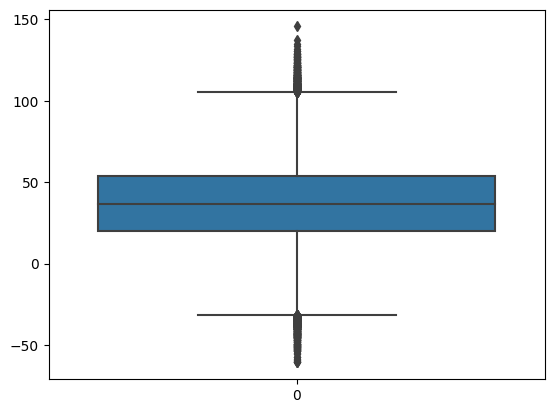

'64'

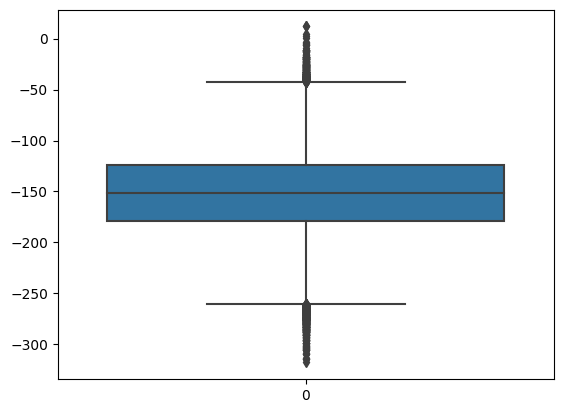

'65'

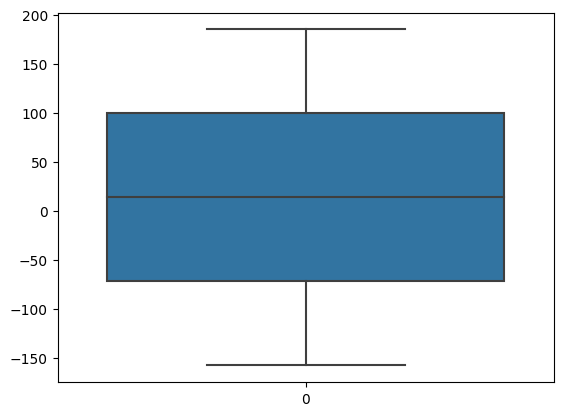

'66'

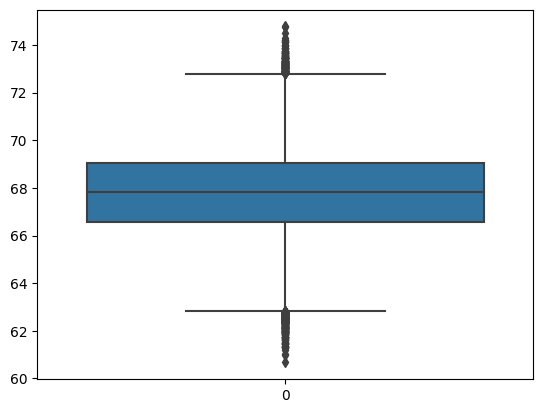

'67'

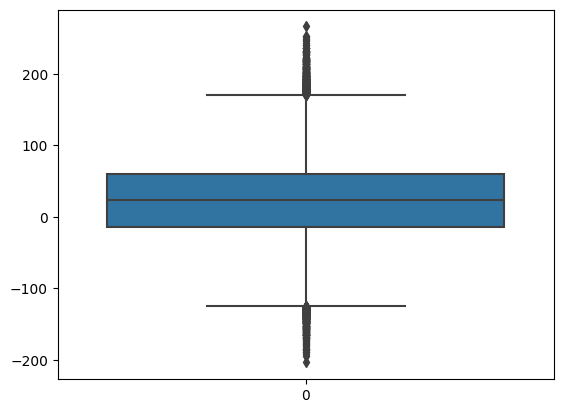

'68'

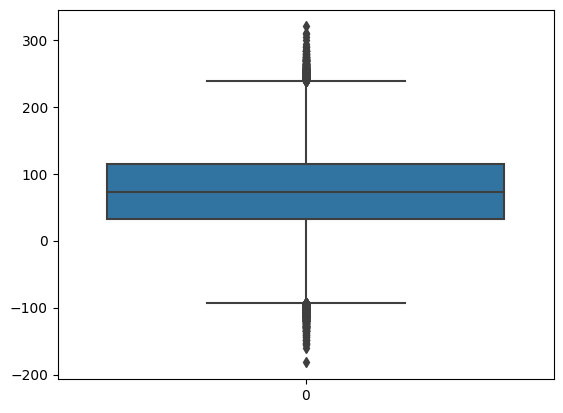

'69'

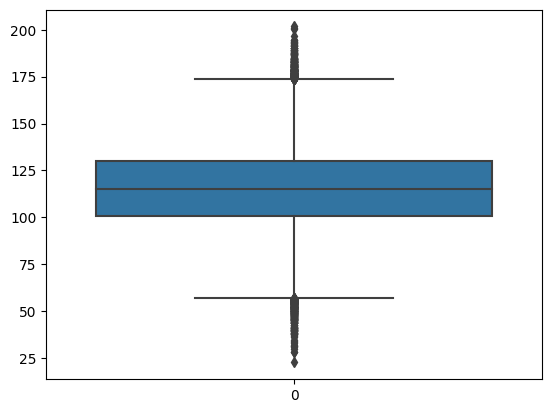

'70'

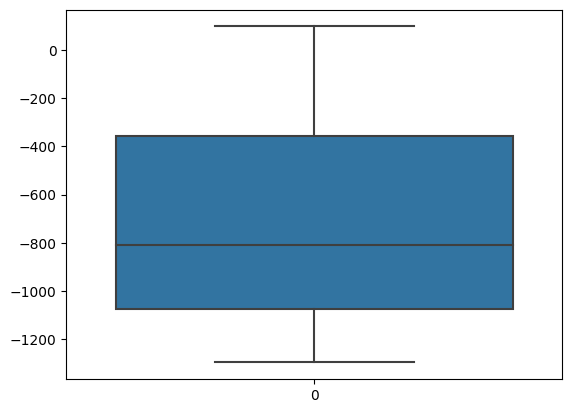

'71'

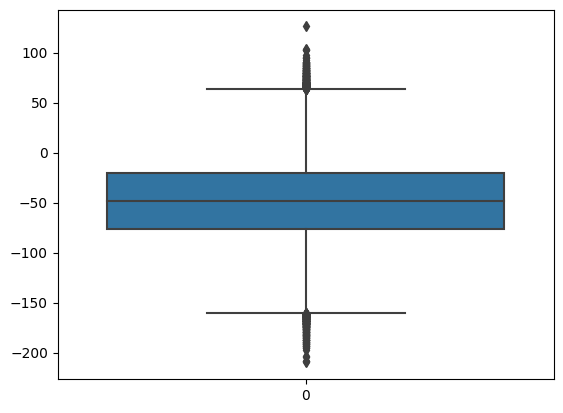

In [75]:
for i in train:
    display(i)
    sns.boxplot(train[i])
    plt.show()

Для большей наглядности решил также вывести гистограммы. Здесь можно заметить, что некоторые признаки представлены неравномерно (6,21,25,70). Они дают мало информации для предсказания и могут негативно повлиять на обучение модели. Далее можно принять решение стоит ли от них отказаться, экспериментальным путем.

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

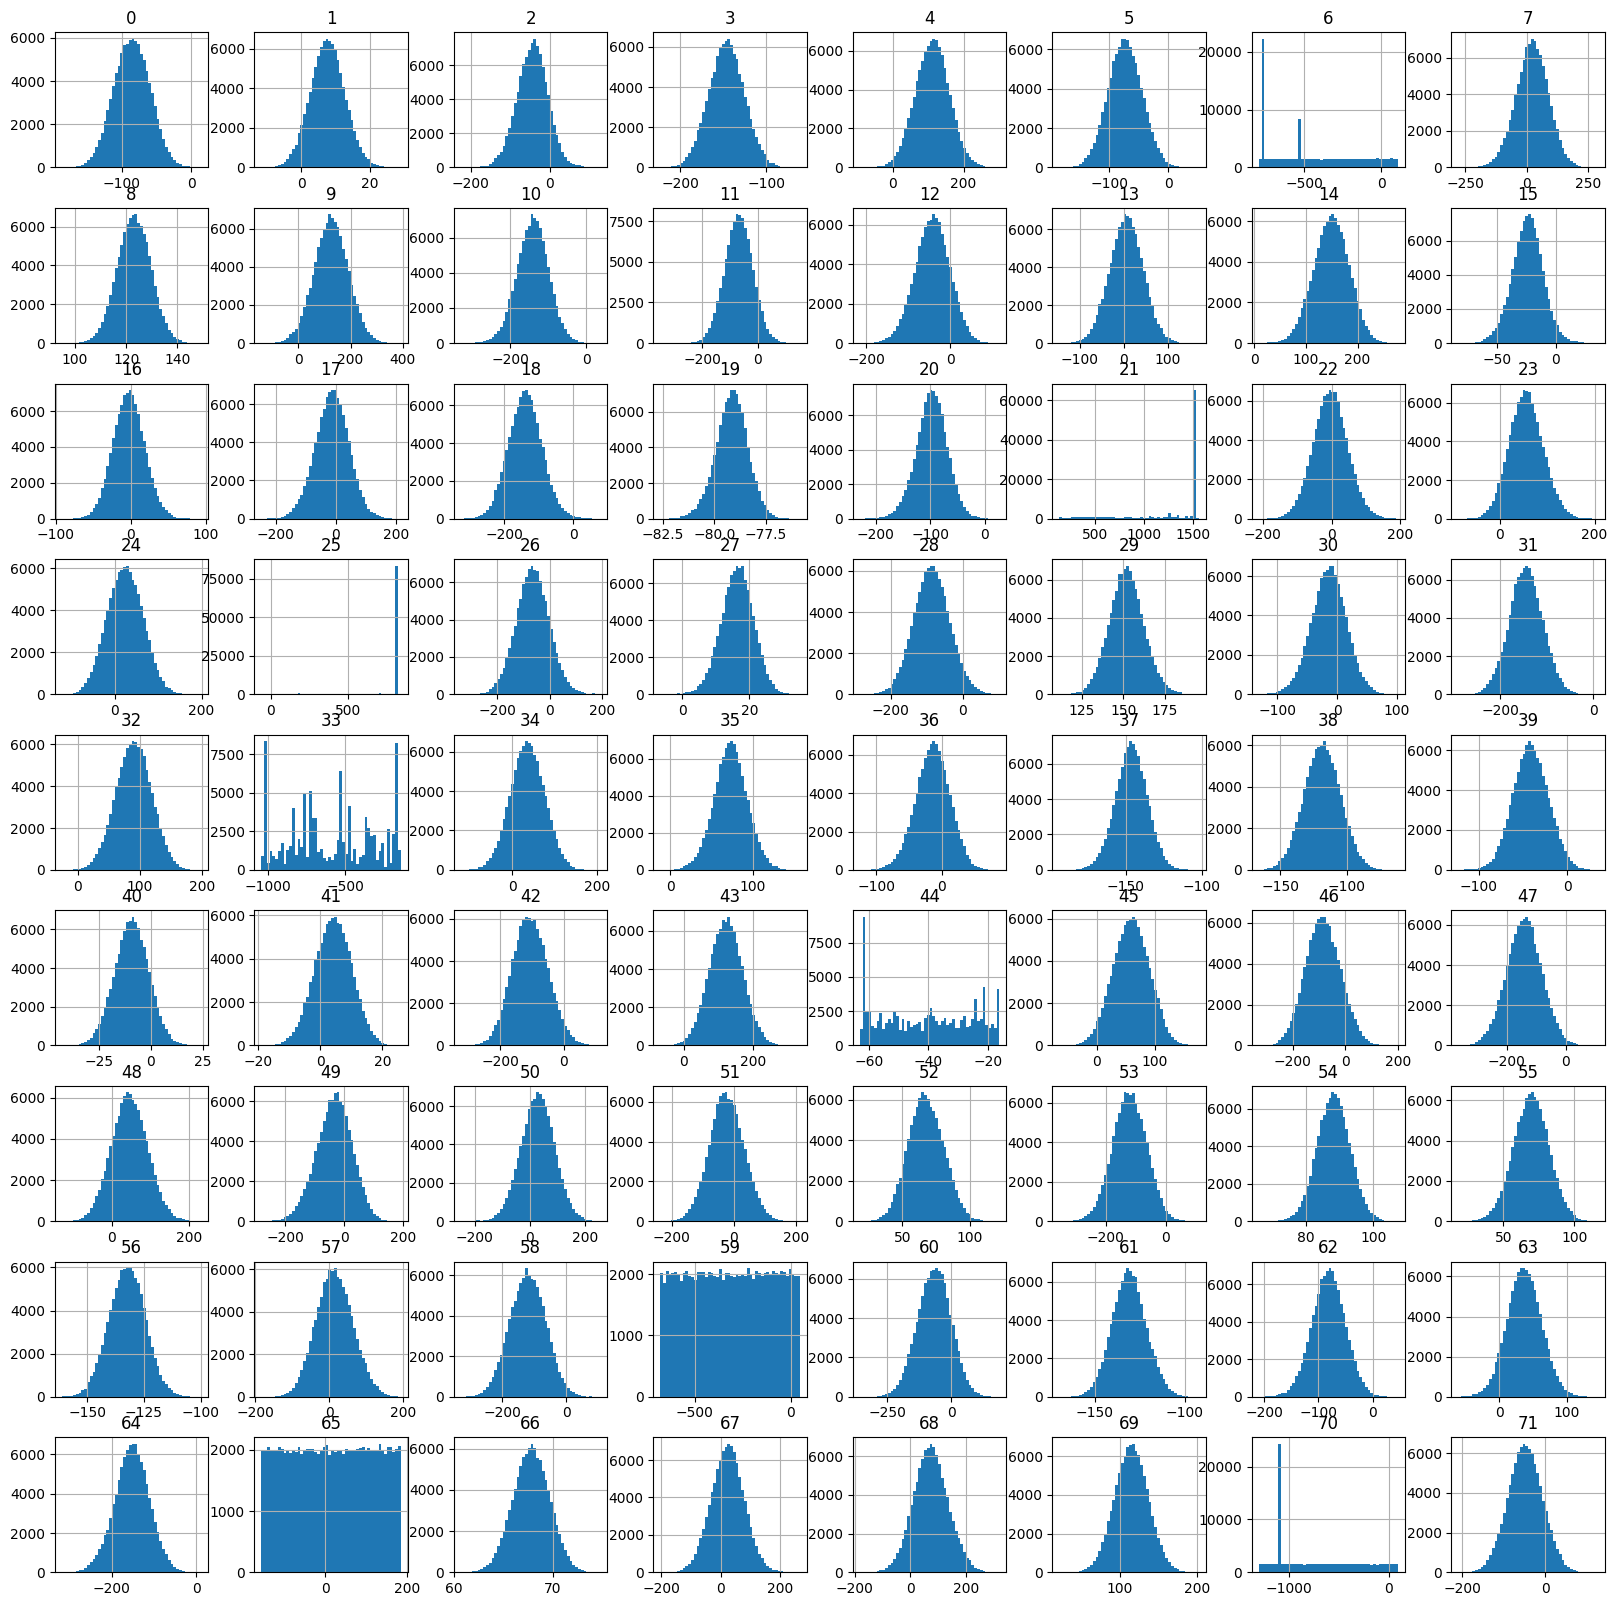

In [76]:
train.hist(figsize=[20, 20], bins=50)

Отказался от нежелательных для обучения признаков.

In [77]:
train = train.drop(['6','21','25','70'], axis = 1)
data = data.drop(['6','21','25','70'], axis = 1)
valid = valid.drop(['6','21','25','70'], axis = 1)

**3. Подготовка данных к обучению и разработка ML модели.**

Задал параметры для фаисса.

In [78]:
dims = data.shape[1]
n_cells = 50
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [79]:
quantizer.ntotal

0

Сохранил в переменную список индексов для соответствия столбцам.

In [80]:
base_index = {k: v for k, v in enumerate(data.index.to_list())}

Обучил фаисс.

In [81]:
idx_l2.train(np.ascontiguousarray(data.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data.values).astype('float32'))

Вычислил показатель accuracy@5 до масштабирования.

In [82]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(train.values).astype('float32'), k)
data.columns
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

4.344
CPU times: user 5min 29s, sys: 329 ms, total: 5min 29s
Wall time: 1min 31s


Записал скейлер в переменную.

In [83]:
scaler = RobustScaler()

Обучил скейлер на оригинальном датафрейме и сразу трансформировал с помощью него оригинальный и тренировочный датасет.

In [84]:
datasc = scaler.fit_transform(data)
trainsc = scaler.transform(train)

Снова задал параметры для фаисса.

In [85]:
dims = datasc.shape[1]
n_cells = 50
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

Обучил фаисс, теперь по смасштабированным данным.

In [86]:
idx_l2.train(np.ascontiguousarray(datasc[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(datasc).astype('float32'))

Попробую сжать индексы при помощи другой функции фаисса. Задал параметры для нее.

In [88]:
sub_quantizer = 68
nbits = 8
quantizerl = faiss.IndexFlatL2(dims)

idxl = faiss.IndexIVFPQ(quantizerl, dims, 50, sub_quantizer, nbits)

Обучил фаисс.

In [89]:
idxl.train(np.ascontiguousarray(datasc[:50000, :]).astype('float32'))
idxl.add(np.ascontiguousarray(datasc).astype('float32'))

Нашел метрику accuracy@5. Ответы этого фаисса можно использовать для обучения модели, поэтому предсказал не 5, а 50 значений. Модель будет искать среди 50 значений наиболее подходящие.

In [90]:
%%time
r, idx = idxl.search(np.ascontiguousarray(trainsc).astype('float32'), 50)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

66.459
CPU times: user 16min 23s, sys: 737 ms, total: 16min 23s
Wall time: 4min 21s


Теперь нужно создать обучающий датафрейм для модели. Каждый предложенный вариант фаисса станет отдельной строкой, в итоге получится 5 миллионов строк.

In [91]:
faiss_idx = pd.DataFrame(idx, index = train.index)
faiss_idx['answer'] = targets
faiss_idx['train_index'] = faiss_idx.index
faiss_idx = pd.melt(faiss_idx, id_vars = ['answer', 'train_index'], value_vars = faiss_idx.columns[:-2], value_name = 'data_index', var_name = 'faiss_answer').sort_values(['data_index', 'faiss_answer'])
display(faiss_idx.shape)
faiss_idx

(5000000, 4)

,answer,train_index,faiss_answer,data_index
1653490,447862,53490,16,0
597760,633447,97760,5,1
2557762,633447,57762,25,1
3815368,1153542,15368,38,1
4333311,84869,33311,43,1
...,...,...,...,...
1507841,431561,7841,15,2918136
2342326,470883,42326,23,2918136
2669148,300612,69148,26,2918136
3745173,31897,45173,37,2918136


Присоединил признаки из тренировочного датасета к обучающему для модели. По этим признакам модель будет учиться.

In [92]:
faiss_idx = faiss_idx.merge(train, left_on = 'train_index', right_index = True )

Сделал отдельный столбец с информацией о корректности ответа фаисса.

In [93]:
faiss_idx['true'] = 0
faiss_idx.loc[faiss_idx['data_index'] == faiss_idx['answer'], 'true'] = 1
faiss_idx['true'].value_counts()

true
0    4933541
1      66459
Name: count, dtype: int64

Исправил тип данных.

In [94]:
faiss_idx['faiss_answer'] = faiss_idx['faiss_answer'].astype('int')
faiss_idx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000000 entries, 1653490 to 3829525
Data columns (total 73 columns):
 #   Column        Dtype  
---  ------        -----  
 0   answer        int64  
 1   train_index   int64  
 2   faiss_answer  int64  
 3   data_index    int64  
 4   0             float32
 5   1             float32
 6   2             float32
 7   3             float32
 8   4             float32
 9   5             float32
 10  7             float32
 11  8             float32
 12  9             float32
 13  10            float32
 14  11            float32
 15  12            float32
 16  13            float32
 17  14            float32
 18  15            float32
 19  16            float32
 20  17            float32
 21  18            float32
 22  19            float32
 23  20            float32
 24  22            float32
 25  23            float32
 26  24            float32
 27  26            float32
 28  27            float32
 29  28            float32
 30  29            flo

Присоединил признаки из оригинального датасета к обучающему для модели. Эти признаки также нужны для обучения.

In [95]:

faiss_idx = faiss_idx.merge(data, left_on = 'data_index', right_index = True)

Проверил размерность датасета. У нас сохранились все наши 5 миллионов строк.

In [96]:
faiss_idx.shape

(5000000, 141)

Сохранил в отдельную переменную признаки, которые не нужны для обучения.

In [97]:
faiss_inform = faiss_idx[['answer', 'train_index', 'true', 'faiss_answer', 'data_index']]

Сохранил в отдельную перменную признаки для обучения

In [98]:
faiss_idx_train = faiss_idx.drop(['answer', 'train_index', 'true', 'faiss_answer', 'data_index'], axis =1)

Сохранил модель LightGBM в перменную и задал ей параметры.

In [99]:
lgbm = ltb.LGBMClassifier(learning_rate = 0.1,
                                class_weight = 'balanced',
                                num_leaves = 30,
                                max_depth = 20,
                                n_estimators = 1000,
                                random_state = 123)

Обучил модель. Обучение занимает около 19 минут.

In [100]:
%%time
lgbm.fit(faiss_idx_train, faiss_inform['true'])

CPU times: user 1h 10min 37s, sys: 14.8 s, total: 1h 10min 52s
Wall time: 19min 5s


LGBMClassifier(class_weight='balanced', max_depth=20, n_estimators=1000,
               num_leaves=30, random_state=123)

**4. Проверка модели на валидационных данных.**

Масштабировал датасет с валидационными данными.

In [101]:
validsc = scaler.transform(valid)

Предсказал ответы при помощи фаисса. 

In [102]:
%%time
r, idx = idxl.search(np.ascontiguousarray(validsc).astype('float32'), 50)

acc = 0
for target, el in zip(expected.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

66.343
CPU times: user 16min 8s, sys: 556 ms, total: 16min 9s
Wall time: 4min 11s


По аналогии с обучающим датасетом, собрал датасет из результатов работы фаисса.

In [103]:
valid_idx = pd.DataFrame(idx, index = valid.index)
valid_idx['answer'] = expected
valid_idx['valid_index'] = valid_idx.index
valid_idx = pd.melt(valid_idx, id_vars = ['answer', 'valid_index'], value_vars = valid_idx.columns[:-2], value_name = 'data_index', var_name = 'faiss_answer').sort_values(['data_index', 'faiss_answer'])
display(valid_idx.shape)
valid_idx

(5000000, 4)

,answer,valid_index,faiss_answer,data_index
2658325,2306423,158325,26,0
1228051,222779,128051,12,1
1914066,197690,114066,19,1
356565,206620,156565,3,2
362689,325616,162689,3,2
...,...,...,...,...
3531304,1160631,131304,35,2918135
4739152,271396,139152,47,2918135
4899642,395517,199642,48,2918135
4659020,392325,159020,46,2918136


Присоединил признаки из валидационного датасета.

In [104]:
valid_idx = valid_idx.merge(valid, left_on = 'valid_index', right_index = True )

Присоединил признаки из оригинального датасета.

In [105]:
valid_idx = valid_idx.merge(data, left_on = 'data_index', right_index = True)

Выделил в отдельную переменную данные для предсказания модели.

In [106]:
valid_idx_train = valid_idx.drop(['answer', 'valid_index', 'faiss_answer', 'data_index'], axis =1)

Предсказал ответы при помощи LightGBM.

In [107]:
%%time
predict = lgbm.predict_proba(valid_idx_train)

CPU times: user 8min 40s, sys: 7.01 s, total: 8min 47s
Wall time: 2min 23s


В предсказаниях модели 2 столбца, нам нужен только один. Сохранил ее в отдельную переменную.

In [108]:
predict = pd.DataFrame(predict)[1]

Обновил инддексы в датасете.

In [109]:
valid_idx = valid_idx.reset_index(drop = True)

Присоединил предсказания к датасету.

In [110]:
valid_idx = valid_idx.merge(predict, left_index = True, right_index = True)

Сохранил в отдельную переменную датасет без признаков.

In [111]:
result = valid_idx[['answer', 'valid_index', 'faiss_answer', 'data_index', 1]]
del valid_idx
result.head()

,answer,valid_index,faiss_answer,data_index,1
0,2306423,158325,26,0,0.000192
1,2306423,158325,19,15468,0.006794
2,51615,152454,30,15468,0.006069
3,2306423,158325,10,154659,0.000089
4,2306423,158325,47,315475,0.000097


Отбросил все лишние строки. Оставил только лучшие 5 ответов для каждого из валидацонных индексов.

In [112]:
result = result.sort_values(by=[1],ascending=False).groupby('valid_index').head(5).sort_values(by=['valid_index'])
display(result.head(50))
result.shape

,answer,valid_index,faiss_answer,data_index,1
2048703,1908173,100000,7,2504096,0.805044
2867336,1908173,100000,27,2546410,0.811335
4629324,1908173,100000,0,2192372,0.855609
4629298,1908173,100000,14,106841,0.880027
4629303,1908173,100000,6,462353,0.849543
2810730,89835,100001,0,157966,0.537424
2810878,89835,100001,1,2528494,0.149762
2810833,89835,100001,3,1902634,0.303438
2810714,89835,100001,2,11829,0.137843
2810789,89835,100001,24,1424395,0.155980


(500000, 5)

Создал столбец для обозначения правильных предсказаний.

In [113]:
result['true'] = 0
result.loc[result['data_index'] == result['answer'], 'true'] = 1

Нашел метрику accuracy@5. Умножил на 5 т.к. только 1 из 5 значений может оказаться верным, однако весь результат из 5 значений считается верным, если хотябы одно из значений совпадает с ответом экспертов.

In [114]:
result['true'].sum()*5 / result['true'].count()

0.62428

**Итоговый результат метрики accuracy@5: 0.624**